# Introdução A computação Visual - Trabalho Prático 3
## Luiz Henrique De Melo Santos
## Otávio Augusto Silva

In [1]:
import os
import cv2
import tqdm
import numba
import numpy
import seaborn
import tensorflow
from matplotlib import pyplot
from tensorflow.keras import activations, callbacks, initializers, layers, losses, metrics, models, optimizers, utils

In [26]:
seaborn.set_style("darkgrid")

In [2]:
devices = tensorflow.config.list_physical_devices()
try:
    tensorflow.config.experimental.set_memory_growth(devices[1], True)
except:
    print(f"Error when enabling memory growth for device {devices[1]}")

In [3]:
VOCAB = "0123456789ABCDEFGHIJKLMNOPQRSTUVXWYZ"
WINDOW_SIZE = 12
STEP_SIZE = 4

In [4]:
labels = {}
for filename in os.listdir(os.path.join("CAPTCHA-10k", "labels10k")):
    with open(os.path.join("CAPTCHA-10k", "labels10k", filename), "r") as file:
        line = file.readlines()[0].rstrip('\n')
        if "?" not in line and len(line) == 6:
            labels[filename.split('.')[0]] = line.replace('\n', '')

In [5]:
vocab_mapping = {i: idx for idx, i in enumerate(VOCAB)}

In [6]:
classes = {}
for key in labels:
    classes[key] = [vocab_mapping[c] for c in labels[key]]

In [49]:
@numba.jit
def sliding_window(image: numpy.ndarray):
    l = []
    for i in range(0, image.shape[1] - WINDOW_SIZE, STEP_SIZE):
        l.append(image[:, i:i + WINDOW_SIZE, :])
    return numpy.array(l)

In [50]:
def train_generator():
    for filename in os.listdir(os.path.join("CAPTCHA-10k", "treinamento")):
        if filename.split('.')[0] in classes.keys():
            image = cv2.imread(os.path.join("CAPTCHA-10k", "treinamento", filename), cv2.IMREAD_GRAYSCALE) / 255
            y = utils.to_categorical(classes[filename.split('.')[0]], num_classes=len(VOCAB))
            #X = numpy.split(image, 6, axis=1)
            X = numpy.split(sliding_window(numpy.expand_dims(image, 2)), 6, axis=0)
            yield (X, y)

In [51]:
def validation_generator():
    for filename in os.listdir(os.path.join("CAPTCHA-10k", "validacao")):
        if filename.split('.')[0] in classes.keys():
            image = cv2.imread(os.path.join("CAPTCHA-10k", "validacao", filename), cv2.IMREAD_GRAYSCALE) / 255
            y = utils.to_categorical(classes[filename.split('.')[0]], num_classes=len(VOCAB))
            #X = numpy.array(numpy.split(image, 6, axis=1))
            X = numpy.split(sliding_window(numpy.expand_dims(image, 2)), 6, axis=0)
            yield (X, y)

In [52]:
def test_generator():
    for filename in os.listdir(os.path.join("CAPTCHA-10k", "teste")):
        if filename.split('.')[0] in classes.keys():
            image = cv2.imread(os.path.join("CAPTCHA-10k", "teste", filename), cv2.IMREAD_GRAYSCALE) / 255
            y = utils.to_categorical(classes[filename.split('.')[0]], num_classes=len(VOCAB))
            X = numpy.split(sliding_window(numpy.expand_dims(image, 2)), 6, axis=0)
            yield (X, y)

In [53]:
def test_generator_captcha():
    for filename in os.listdir(os.path.join("CAPTCHA-10k", "teste")):
        if filename.split('.')[0] in classes.keys():
            image = cv2.imread(os.path.join("CAPTCHA-10k", "teste", filename), cv2.IMREAD_GRAYSCALE)
            y = utils.to_categorical(classes[filename.split('.')[0]], num_classes=len(VOCAB))
            yield (numpy.expand_dims(image, 2), y)

In [54]:
train_dataset = tensorflow.data.Dataset.from_generator(train_generator, (tensorflow.dtypes.float32, tensorflow.dtypes.uint8), output_shapes=(tensorflow.TensorShape((6, None, 50, WINDOW_SIZE, 1)), tensorflow.TensorShape((6, 36)))).unbatch()

In [55]:
validation_dataset = tensorflow.data.Dataset.from_generator(validation_generator, (tensorflow.dtypes.float32, tensorflow.dtypes.uint8), output_shapes=(tensorflow.TensorShape((6, None, 50, WINDOW_SIZE, 1)), tensorflow.TensorShape((6, 36)))).unbatch()

In [56]:
test_dataset = tensorflow.data.Dataset.from_generator(test_generator, (tensorflow.dtypes.float32, tensorflow.dtypes.uint8), output_shapes=(tensorflow.TensorShape((6, None, 50, WINDOW_SIZE, 1)), tensorflow.TensorShape((6, 36)))).unbatch()

In [57]:
test_dataset_captcha =  tensorflow.data.Dataset.from_generator(test_generator_captcha, (tensorflow.dtypes.uint8, tensorflow.dtypes.uint8), output_shapes=(tensorflow.TensorShape((50, 180, 1)), tensorflow.TensorShape((6, 36))))

In [58]:
def create_model(shape: tuple) -> models.Model:
    inputs = tensorflow.keras.Input(shape)
    x = layers.Conv3D(32, kernel_size=(3, 3, 3), padding="same", bias_initializer=initializers.Ones())(inputs)
    x = layers.PReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(64, kernel_size=(3, 3, 3), padding="same", bias_initializer=initializers.Ones())(x)
    x = layers.PReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool3D()(x)
    x = layers.Conv3D(64, kernel_size=(3, 3, 3), padding="same", bias_initializer=initializers.Ones())(x)
    x = layers.PReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(128, kernel_size=(3, 3, 3), padding="same", bias_initializer=initializers.Ones())(x)
    x = layers.PReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool3D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation=activations.linear, bias_initializer=initializers.Ones())(x)
    x = layers.PReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation=activations.linear, bias_initializer=initializers.Ones())(x)
    x = layers.PReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(VOCAB), activation=activations.softmax, bias_initializer=tensorflow.ones)(x)
    return models.Model(inputs=inputs, outputs=outputs)

In [59]:
for item, _ in train_dataset.take(1):
    model = create_model(item.shape)

In [60]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 50, 12, 1)]    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 50, 12, 32)     896       
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 7, 50, 12, 32)     134400    
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 50, 12, 32)     128       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 7, 50, 12, 64)     55360     
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 7, 50, 12, 64)     268800    
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 50, 12, 64)     256 

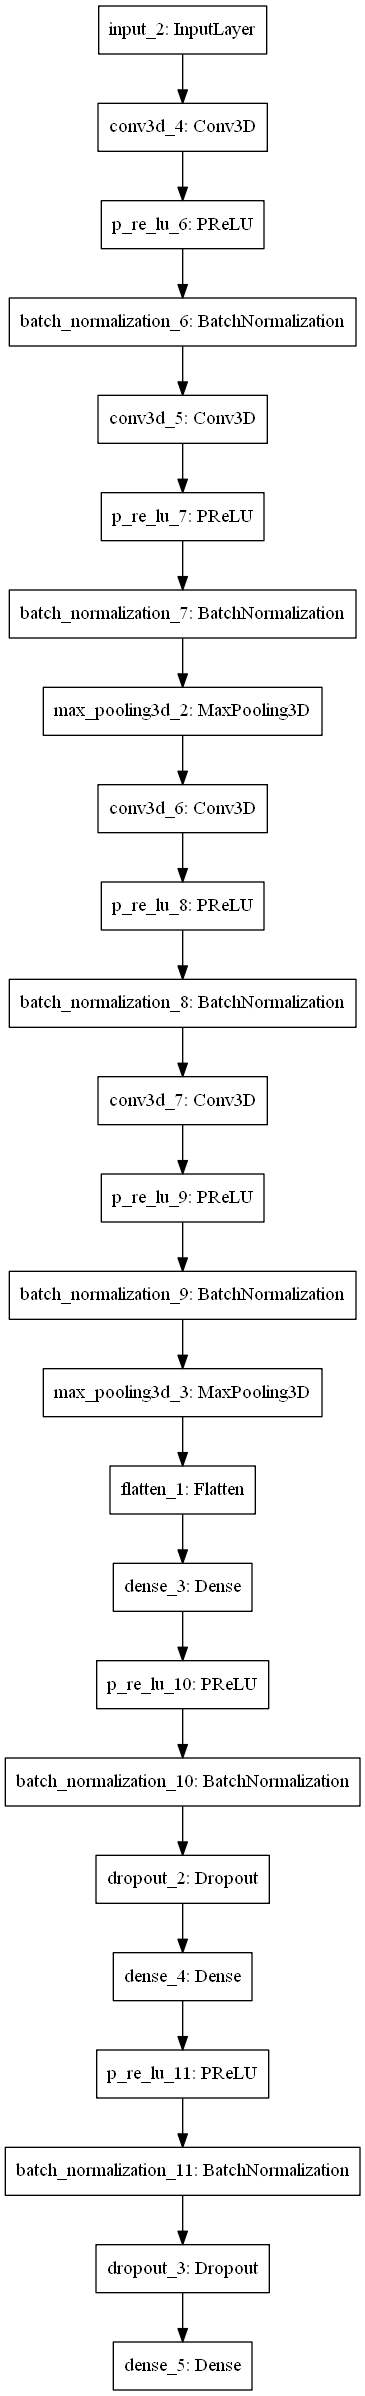

In [61]:
utils.plot_model(model)

In [62]:
model.compile(optimizer=optimizers.Adam(), loss=losses.CategoricalCrossentropy(), metrics=[metrics.CategoricalAccuracy()])

In [63]:
if not os.path.exists("log"):
    os.makedirs("log")
tensorboard_callback = callbacks.TensorBoard(log_dir="log", histogram_freq=1, write_images=True)

In [64]:
history = model.fit(train_dataset.batch(256), validation_data=validation_dataset.batch(256), epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10
186/186 [==============================] - 114s 614ms/step - loss: 1.2063 - categorical_accuracy: 0.6492 - val_loss: 1.8455 - val_categorical_accuracy: 0.4745
Epoch 2/10
186/186 [==============================] - 110s 590ms/step - loss: 0.3983 - categorical_accuracy: 0.8809 - val_loss: 0.4376 - val_categorical_accuracy: 0.8804
Epoch 3/10
186/186 [==============================] - 112s 604ms/step - loss: 0.2790 - categorical_accuracy: 0.9145 - val_loss: 0.2445 - val_categorical_accuracy: 0.9206
Epoch 4/10
186/186 [==============================] - 112s 601ms/step - loss: 0.2284 - categorical_accuracy: 0.9298 - val_loss: 0.2678 - val_categorical_accuracy: 0.9084
Epoch 5/10
186/186 [==============================] - 112s 601ms/step - loss: 0.1891 - categorical_accuracy: 0.9401 - val_loss: 0.2155 - val_categorical_accuracy: 0.9361
Epoch 6/10
186/186 [==============================] - 112s 600ms/step - loss: 0.1621 - categorical_accuracy: 0.9482 - val_loss: 0.2003 - val_categoric

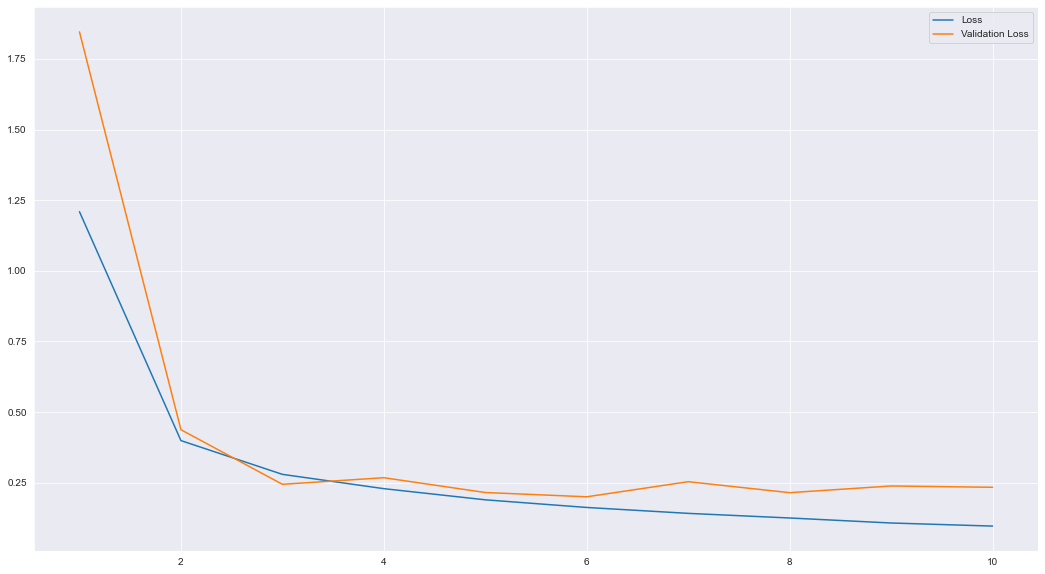

In [65]:
pyplot.figure(figsize=(18, 10))
seaborn.lineplot(x=range(1, 11), y=history.history["loss"], label="Loss")
seaborn.lineplot(x=range(1, 11), y=history.history["val_loss"], label="Validation Loss")
pyplot.show()

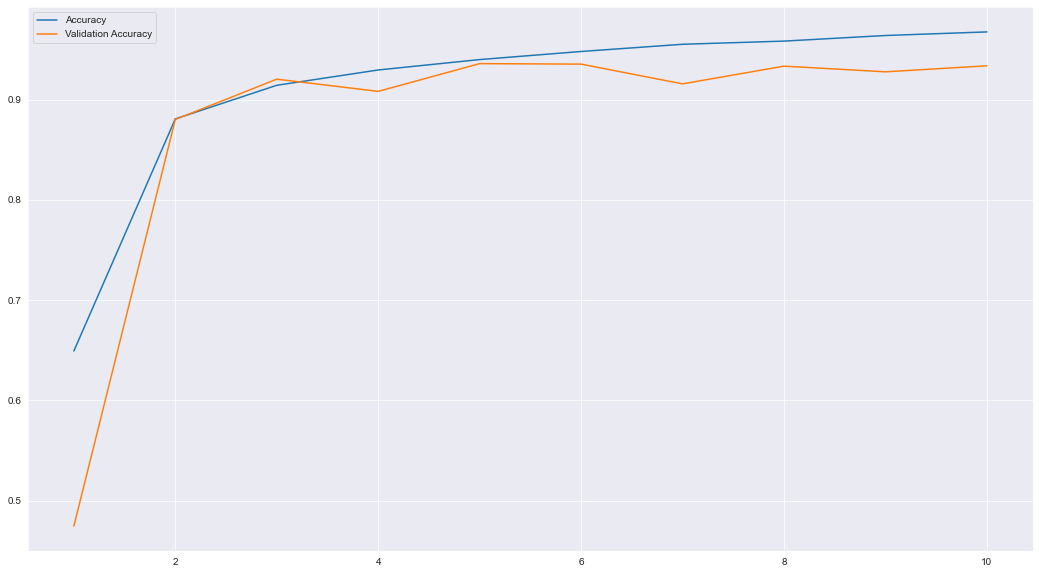

In [67]:
pyplot.figure(figsize=(18, 10))
seaborn.lineplot(x=range(1, 11), y=history.history["categorical_accuracy"], label="Accuracy")
seaborn.lineplot(x=range(1, 11), y=history.history["val_categorical_accuracy"], label="Validation Accuracy")
pyplot.show()

In [68]:
model.save("model.h5", save_format="h5")

In [69]:
loss, accuracy = model.evaluate(test_dataset.batch(256))

     24/Unknown - 4s 177ms/step - loss: 0.2298 - categorical_accuracy: 0.9329

In [70]:
print(f"Test loss: {loss}\nTest Acuracy: {accuracy}")

Test loss: 0.22980485980709395
Test Acuracy: 0.9329329133033752


In [71]:
def diff_count(y_true: str, y_pred: str) -> float:
    k = 0
    for i, j in zip(y_true, y_pred):
        if i == j:
            k += 1
    return k / 6

In [72]:
def evaluate(dataset: tensorflow.data.Dataset):
    with open("predictions.txt", "w") as file, tqdm.tqdm(total=len(list(dataset))) as pbar:
        j, k = 0, 0
        cc = losses.CategoricalCrossentropy()
        l, ac = [], []
        for item, label in dataset:
            x = sliding_window(item)
            X = tensorflow.convert_to_tensor(tensorflow.split(x, 6, axis=0)) / 255
            #print(X.shape)
            p = model.predict(X)
            #print(p.shape)
            loss = cc(label, p)
            l.append(loss)
            pbar.update(1)
            j += 1
            if j % 10 == 0:
                pbar.set_description_str(f"Loss: {loss.numpy()}")
            s_true, s_pred = "", ""
            for i in range(label.shape[0]):
                idx = tensorflow.argmax(label[i])
                s_true += VOCAB[idx.numpy()]
                idx = tensorflow.argmax(p[i])
                s_pred += VOCAB[idx.numpy()]
            if s_true == s_pred:
                file.write(f"Label: {s_true}, Predicted: {s_pred}, Loss: {loss.numpy()}\n")
                ac.append(1)
                k += 1
            else:
                file.write(f"Label: {s_true}, Predicted: {s_pred}, Loss: {loss.numpy()}, Wrong answer!\n")
                ac.append(diff_count(s_true, s_pred))
    print(f"\nMean  loss: {tensorflow.reduce_mean(l).numpy()}, CAPTCHA accuracy: {k / j}, Mean accuracy: {tensorflow.reduce_mean(ac).numpy()}")

In [73]:
evaluate(test_dataset_captcha)

Loss: 0.010673289187252522: 100%|██████████| 999/999 [01:02<00:00, 16.11it/s]
Mean  loss: 0.2285022884607315, CAPTCHA accuracy: 0.6576576576576577, Mean accuracy: 0.9329329133033752

